<a href="https://colab.research.google.com/github/zainmo11/Credit_card_fraud_Detection/blob/main/Credit_card_fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **01. Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# **02. Load Dataset**

In [2]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0


In [4]:
!unzip creditcardfraud.zip


Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [5]:
original_df = pd.read_csv('creditcard.csv')
original_df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [6]:
original_df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [7]:
# Make Time column as int64 and Class as boolean
original_df['Time'] = original_df['Time'].astype('int64')
original_df['Class'] = original_df['Class'].astype('bool')


In [8]:
original_df.dtypes

Time        int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class        bool
dtype: object

In [9]:
original_df.tail()

Time         V1         V2        V3        V4        V5        V6  \
284802  172786 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  172787  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804  172788   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  172788  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  172792  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9  ...       V21       V22       V23  \
284802 -4.918215  7.305334  1.914428  ...  0.213454  0.111864  1.014480   
284803  0.024330  0.294869  0.584800  ...  0.214205  0.924384  0.012463   
284804 -0.296827  0.708417  0.432454  ...  0.232045  0.578229 -0.037501   
284805 -0.686180  0.679145  0.392087  ...  0.265245  0.800049 -0.163298   
284806  1.577006 -0.414650  0.486180  ...  0.261057  0.643078  0.376777   

             V24       V25       V26       V27       V28  Amount  Class  
284802 -0.509348  1.436807  0.250034  0.943651  0.823731    0.77  False  
284803 -1.016226 -0.606624 -0.395255  0.068472 -0.053527   24.79  False  
284804  0.640134  0.265745 -0.087371  0.004455 -0.026561   67.88  False  
284805  0.123205 -0.569159  0.546668  0.108821  0.104533   10.00  False  
284806  0.008797 -0.473649 -0.818267 -0.002415  0.013649  217.00  False  

[5 rows x 31 columns]

# **03. Data Issues**

In [10]:
# check missing values
print("Missing Values:",original_df.isnull().sum())

Missing Values: Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [11]:
# check duplicate
print("Duplicates:",original_df.duplicated().sum())

Duplicates: 1081


In [12]:
# Display some duplicate rows for inspection
duplicate_rows = original_df[original_df.duplicated(keep=False)]
print("\nSample of Duplicate Rows:\n", duplicate_rows.head())


Sample of Duplicate Rows:
      Time        V1        V2        V3        V4        V5        V6  \
32     26 -0.529912  0.873892  1.347247  0.145457  0.414209  0.100223   
33     26 -0.529912  0.873892  1.347247  0.145457  0.414209  0.100223   
34     26 -0.535388  0.865268  1.351076  0.147575  0.433680  0.086983   
35     26 -0.535388  0.865268  1.351076  0.147575  0.433680  0.086983   
112    74  1.038370  0.127486  0.184456  1.109950  0.441699  0.945283   

           V7        V8        V9  ...       V21       V22       V23  \
32   0.711206  0.176066 -0.286717  ...  0.046949  0.208105 -0.185548   
33   0.711206  0.176066 -0.286717  ...  0.046949  0.208105 -0.185548   
34   0.693039  0.179742 -0.285642  ...  0.049526  0.206537 -0.187108   
35   0.693039  0.179742 -0.285642  ...  0.049526  0.206537 -0.187108   
112 -0.036715  0.350995  0.118950  ...  0.102520  0.605089  0.023092   

          V24       V25       V26       V27       V28  Amount  Class  
32   0.001031  0.098816 -0.55

In [13]:
# Check if duplicates are fraud or non-fraud
duplicate_class_dist = duplicate_rows['Class'].value_counts()
print("\nClass Distribution of Duplicates:\n", duplicate_class_dist)


Class Distribution of Duplicates:
 Class
False    1822
True       32
Name: count, dtype: int64


In [14]:
# Number of every class
class_dist = original_df['Class'].value_counts()
class_dist

Class
False    284315
True        492
Name: count, dtype: int64

In [15]:
# Calculate the percentage of duplicates for each class
fraud_percentage = (duplicate_class_dist.get(1, 0) / class_dist.get(1, 0)) * 100
non_fraud_percentage = (duplicate_class_dist.get(0, 0) / class_dist.get(0, 0)) * 100

# Print the percentages
print(f"Percentage of Duplicate Non-Fraud Transactions: {non_fraud_percentage:.2f}%")
print(f"\nPercentage of Duplicate Fraud Transactions: {fraud_percentage:.2f}%")

Percentage of Duplicate Non-Fraud Transactions: 0.64%

Percentage of Duplicate Fraud Transactions: 6.50%


**Note:** So, it is better to remove **duplicates**

Summary Statistics for Amount:
 count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

Summary Statistics for Time:
 count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64


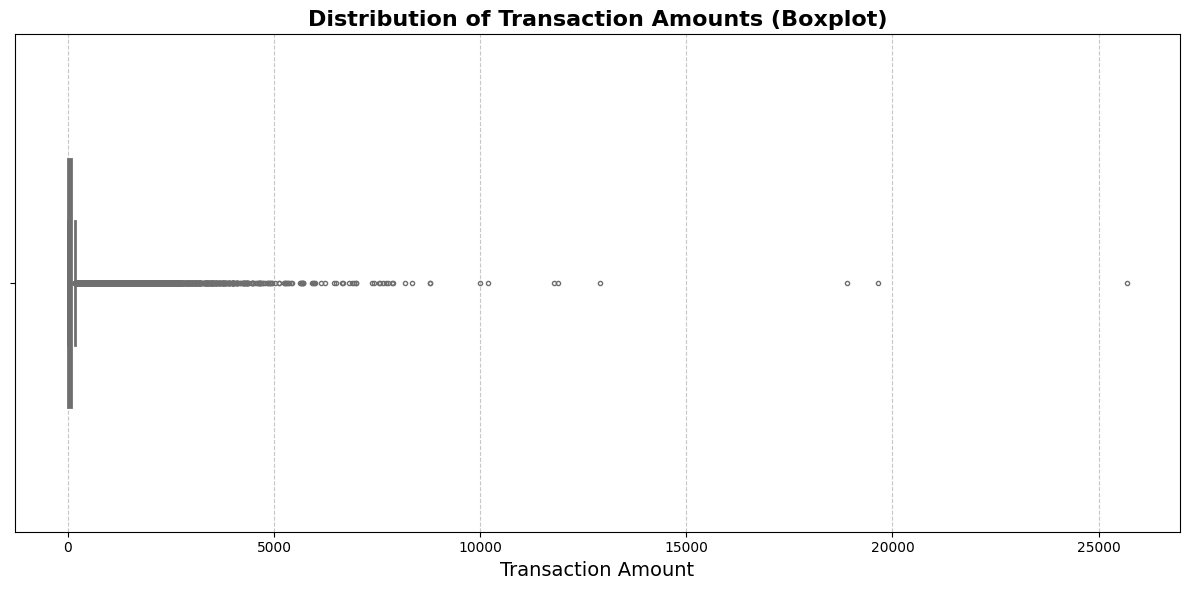

Number of Outliers in Amount: 31904
Percentage of Outliers: 11.202%


In [16]:
# Summary statistics for 'Amount' and 'Time'
print("Summary Statistics for Amount:\n", original_df['Amount'].describe())
print("\nSummary Statistics for Time:\n", original_df['Time'].describe())

# Boxplot for 'Amount' to visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=original_df,
    x='Amount',
    color='skyblue',
    width=0.5,
    fliersize=3,
    linewidth=2
)
plt.title('Distribution of Transaction Amounts (Boxplot)', fontsize=16, fontweight='bold')
plt.xlabel('Transaction Amount', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Calculate IQR for 'Amount' to quantify outliers
Q1 = original_df['Amount'].quantile(0.25)
Q3 = original_df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = original_df[(original_df['Amount'] < lower_bound) | (original_df['Amount'] > upper_bound)]['Amount']
print("Number of Outliers in Amount:", len(outliers))
print("Percentage of Outliers: {:.3f}%".format((len(outliers) / len(original_df)) * 100))

# **04. Data Preprocessing and Visualization**


### Data Types Used in This Project

We will work with three categories of data:

1. **Original Data**

2. **Cleaned Data**, which includes:
   - **Undersampled Data**
   - **Oversampled Data** (using **SMOTE**)


In [17]:
# Remove duplicates
df_Cleaned = original_df.copy()
df_Cleaned.drop_duplicates(inplace=True)
# check duplicate
print("Duplicates:",df_Cleaned.duplicated().sum())

Duplicates: 0


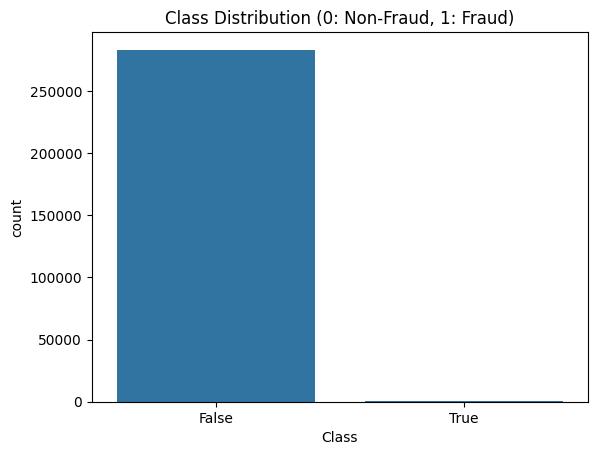

In [18]:
# Visualize class distribution
sns.countplot(x='Class', data=df_Cleaned)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.show()

Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud.


we don't want our model to assume, we want our model to detect patterns that give signs of fraud

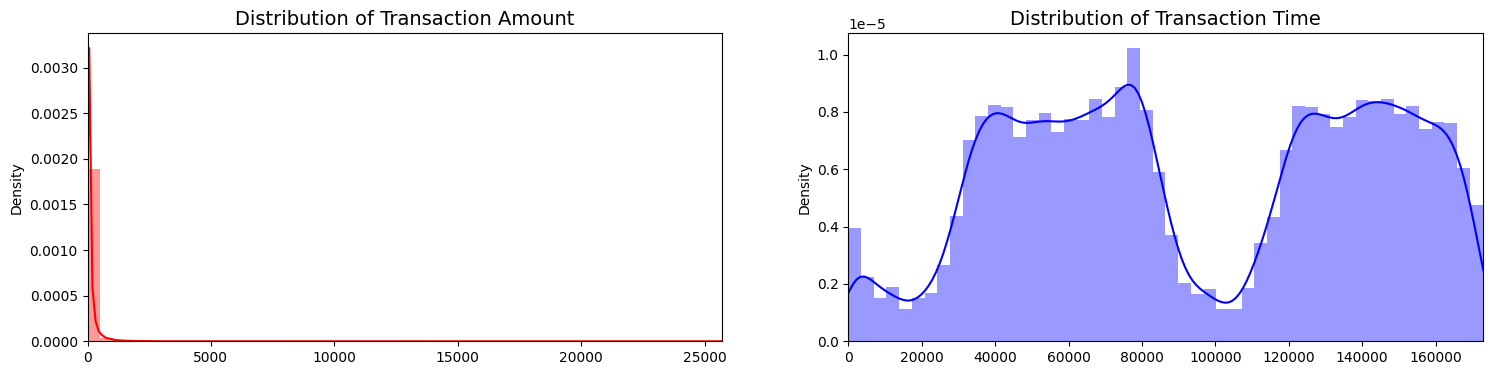

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df_Cleaned['Amount'].values
time_val = df_Cleaned['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [20]:
# # Outlier Capping for 'Amount'
# Q1 = df_Cleaned['Amount'].quantile(0.25)
# Q3 = df_Cleaned['Amount'].quantile(0.75)
# IQR = Q3 - Q1
# upper_bound = Q3 + 1.5 * IQR
# df_Cleaned['Amount'] = np.where(df_Cleaned['Amount'] > upper_bound, upper_bound, df_Cleaned['Amount'])



> Making outlier Capping reduce correlation at this case



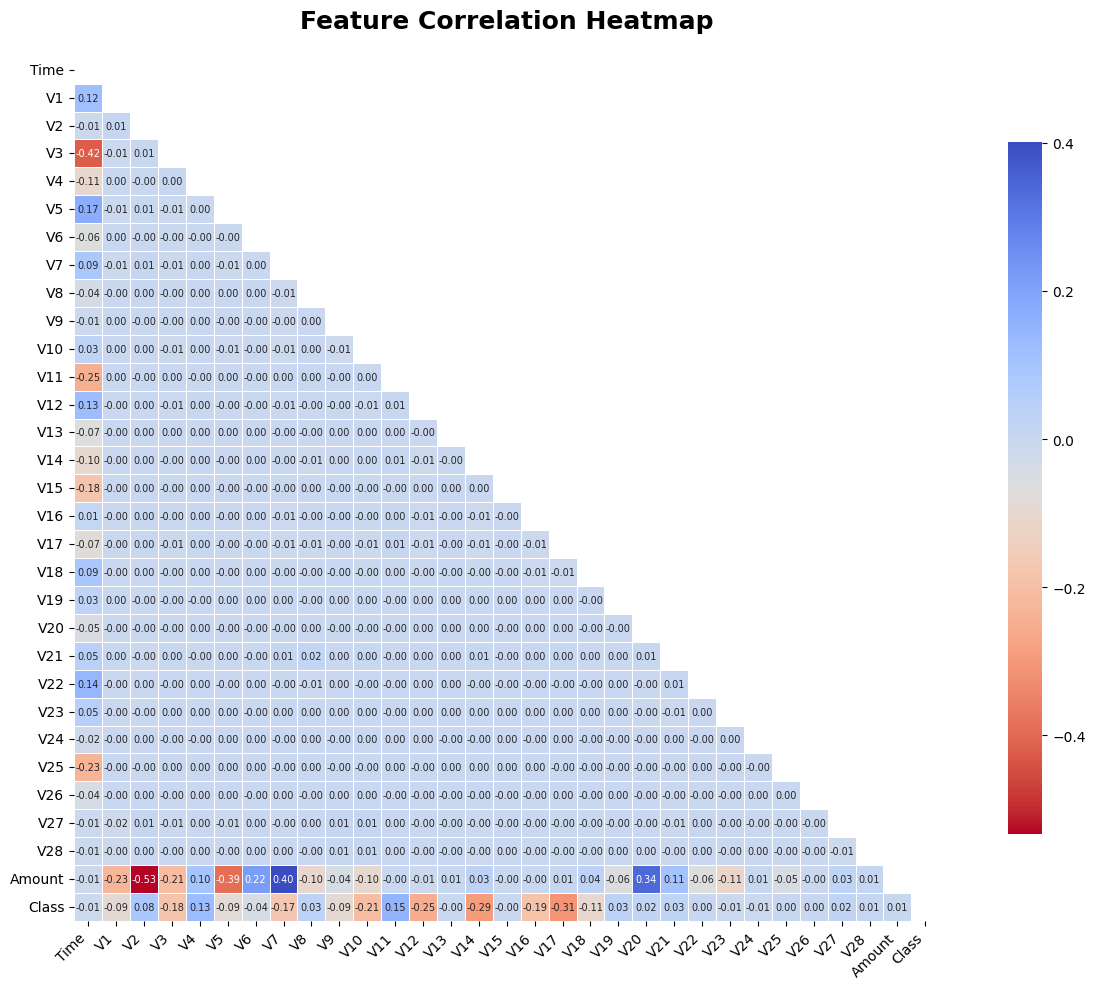

In [21]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
corr = df_Cleaned.corr()

sns.heatmap(
    corr,
    cmap='coolwarm_r',
    annot=True,
    annot_kws={'size': 7},
    fmt='.2f',
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={"shrink": 0.8},
    mask=np.triu(corr)
)

plt.title('Feature Correlation Heatmap', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Feature pairs with correlation > 0.07:
    Feature1 Feature2  correlation
0       Time       V1     0.117927
2       Time       V3    -0.422054
3       Time       V4    -0.105845
4       Time       V5     0.173223
6       Time       V7     0.085335
10      Time      V11    -0.248536
11      Time      V12     0.125500
13      Time      V14    -0.100316
14      Time      V15    -0.184392
16      Time      V17    -0.073819
17      Time      V18     0.090305
21      Time      V22     0.143727
24      Time      V25    -0.233262
57        V1   Amount    -0.230105
58        V1    Class    -0.094486
85        V2   Amount    -0.533428
86        V2    Class     0.084624
112       V3   Amount    -0.212410
113       V3    Class    -0.182322
138       V4   Amount     0.099514
139       V4    Class     0.129326
163       V5   Amount    -0.387685
164       V5    Class    -0.087812
187       V6   Amount     0.216389
210       V7   Amount     0.400408
211       V7    Class    -0.172347
232       V8   A

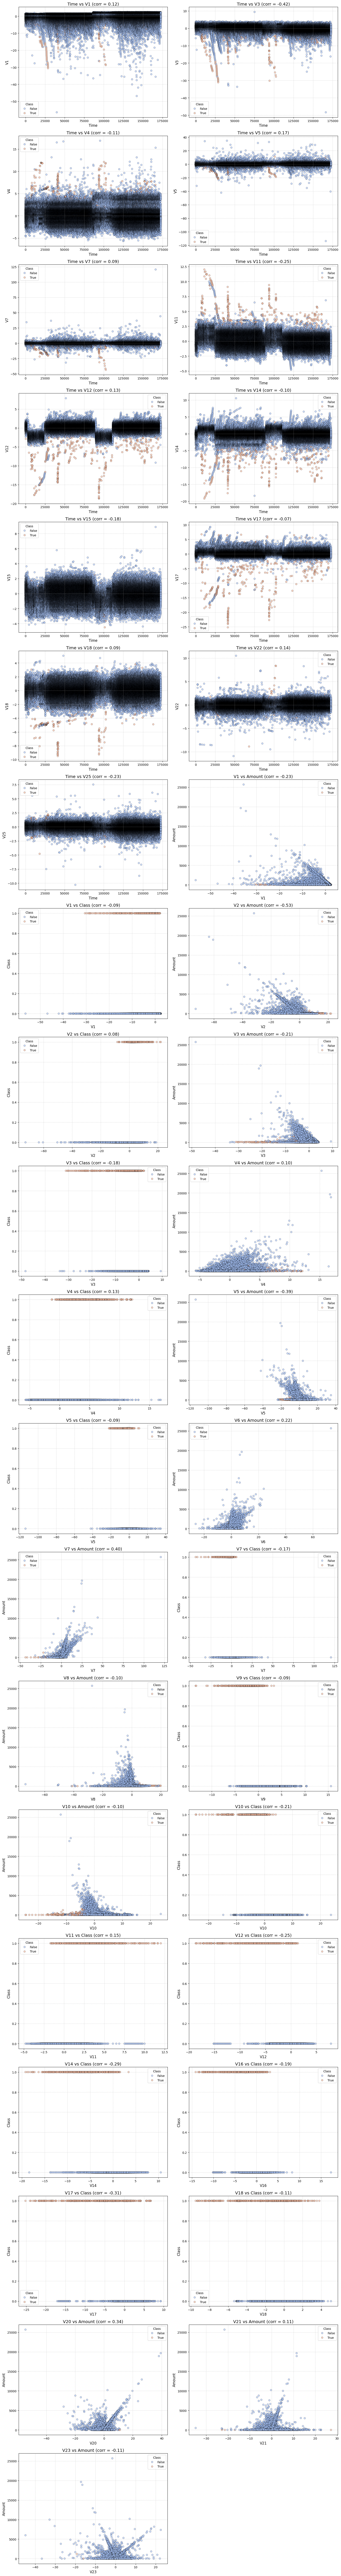

In [22]:
# Compute the correlation matrix
corr = df_Cleaned.corr()

# Find feature pairs with correlation > 0.07 (absolute)
high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={0: 'correlation', 'level_0': 'Feature1', 'level_1': 'Feature2'})
)

# Filter pairs with |correlation| > 0.07 and exclude 'Class'
high_corr_pairs = high_corr_pairs[
    (np.abs(high_corr_pairs['correlation']) > 0.07) #&
    # (high_corr_pairs['Feature1'] != 'Class') &
    # (high_corr_pairs['Feature2'] != 'Class')
]
print(f"Feature pairs with correlation > 0.07:\n{high_corr_pairs}")

# Plot two graphs per row
n_cols = 2
n_rows = (len(high_corr_pairs) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
axes = axes.flatten()

for idx, (ax, (_, row)) in enumerate(zip(axes, high_corr_pairs.iterrows())):
    sns.scatterplot(
        data=df_Cleaned,
        x=row['Feature1'],
        y=row['Feature2'],
        hue='Class',
        palette='coolwarm',
        alpha=0.6,
        edgecolor='k',
        ax=ax
    )
    ax.set_title(f"{row['Feature1']} vs {row['Feature2']} (corr = {row['correlation']:.2f})", fontsize=14)
    ax.set_xlabel(row['Feature1'], fontsize=12)
    ax.set_ylabel(row['Feature2'], fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide any empty subplots
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Insights from Feature Correlations

### **Time correlations:**
- **Time** shows moderate negative correlation with **V3 (-0.42)** and smaller negative correlations with **V10**, **V14**, and **V15**.
- **Time** shows small positive correlations with **V5 (0.17)**, **V22 (0.14)**, **V12 (0.13)**, **V1 (0.12)**, **V18 (0.09)**, and **V7 (0.085)**.

### **Feature correlations with Amount:**
- **V2** has the strongest negative correlation with **Amount (-0.53)**.
- **V5 (-0.39)** and **V1 (-0.23)** also have noticeable negative correlations with Amount.
- **V7** shows a moderate positive correlation with **Amount (0.40)**.
- **V20** shows a positive correlation with **Amount (0.34)**.
- Other features with smaller correlations: **V6 (0.22)**, **V21 (0.11)**, **V4 (0.10)**.

### **Feature correlations with Class (target variable):**
- **V17** has the strongest negative correlation with **Class (-0.31)**.
- **V14 (-0.29)**, **V12 (-0.25)**, and **V10 (-0.21)** also show moderate negative correlations with Class.
- **V16 (-0.19)** and **V18 (-0.10)** also have negative correlations.
- Positive correlations: **V11 (0.15)** and **V4 (0.13)**.

### **General observations:**
- Most features have weak to moderate correlations with **Class**, suggesting no single feature fully separates the classes.
- Features with stronger correlation (|correlation| > **0.25**) could be important for **modeling** or **feature selection**.
- The dataset might benefit from **feature engineering**, **feature selection**, or creating **interaction features** to boost predictive power.


<div style="text-align: center;">
    🔵 It means we need to combine multiple features together (through a model like Logistic Regression, Decision Trees, etc.) to get a good prediction. <br>
    🔵 Feature engineering or combining features will be important because single features alone aren't enough.
</div>

In [23]:
details = original_df.describe().T
details


count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.168375e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.416908e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.074095e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  9.604066e-16      1.380247 -113.743307     -0.691597   
V6      284807.0  1.487313e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.556467e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.213481e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.406331e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  2.239053e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  1.673327e-15      1.020713   -4.797473     -0.762494   
V12     284807.0 -1.247012e-15      0.999201  -18.683715     -0.405571   
V13     284807.0  8.190001e-16      0.995274   -5.791881     -0.648539   
V14     284807.0  1.207294e-15      0.958596  -19.214325     -0.425574   
V15     284807.0  4.887456e-15      0.915316   -4.498945     -0.582884   
V16     284807.0  1.437716e-15      0.876253  -14.129855     -0.468037   
V17     284807.0 -3.772171e-16      0.849337  -25.162799     -0.483748   
V18     284807.0  9.564149e-16      0.838176   -9.498746     -0.498850   
V19     284807.0  1.039917e-15      0.814041   -7.213527     -0.456299   
V20     284807.0  6.406204e-16      0.770925  -54.497720     -0.211721   
V21     284807.0  1.654067e-16      0.734524  -34.830382     -0.228395   
V22     284807.0 -3.568593e-16      0.725702  -10.933144     -0.542350   
V23     284807.0  2.578648e-16      0.624460  -44.807735     -0.161846   
V24     284807.0  4.473266e-15      0.605647   -2.836627     -0.354586   
V25     284807.0  5.340915e-16      0.521278  -10.295397     -0.317145   
V26     284807.0  1.683437e-15      0.482227   -2.604551     -0.326984   
V27     284807.0 -3.660091e-16      0.403632  -22.565679     -0.070840   
V28     284807.0 -1.227390e-16      0.330083  -15.430084     -0.052960   
Amount  284807.0  8.834962e+01    250.120109    0.000000      5.600000   

                 50%            75%            max  
Time    84692.000000  139320.500000  172792.000000  
V1          0.018109       1.315642       2.454930  
V2          0.065486       0.803724      22.057729  
V3          0.179846       1.027196       9.382558  
V4         -0.019847       0.743341      16.875344  
V5         -0.054336       0.611926      34.801666  
V6         -0.274187       0.398565      73.301626  
V7          0.040103       0.570436     120.589494  
V8          0.022358       0.327346      20.007208  
V9         -0.051429       0.597139      15.594995  
V10        -0.092917       0.453923      23.745136  
V11        -0.032757       0.739593      12.018913  
V12         0.140033       0.618238       7.848392  
V13        -0.013568       0.662505       7.126883  
V14         0.050601       0.493150      10.526766  
V15         0.048072       0.648821       8.877742  
V16         0.066413       0.523296      17.315112  
V17        -0.065676       0.399675       9.253526  
V18        -0.003636       0.500807       5.041069  
V19         0.003735       0.458949       5.591971  
V20        -0.062481       0.133041      39.420904  
V21        -0.029450       0.186377      27.202839  
V22         0.006782       0.528554      10.503090  
V23        -0.011193       0.147642      22.528412  
V24         0.040976       0.439527       4.584549  
V25         0.016594       0.350716       7.519589  
V26        -0.052139       0.240952       3.517346  
V27         0.001342       0.091045      31.612198  
V28         0.011244       0.078280      33.847808  
Amount     22.000000      77.165000   25691.160000



> **We need to make Scaler to amount and Time**



In [24]:
from sklearn.preprocessing import StandardScaler, RobustScaler


# make Robust Scaler
rob_scaler = RobustScaler()

df_Cleaned['scaled_amount'] = rob_scaler.fit_transform(df_Cleaned['Amount'].values.reshape(-1,1))
df_Cleaned['scaled_time'] = rob_scaler.fit_transform(df_Cleaned['Time'].values.reshape(-1,1))

df_Cleaned.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df_Cleaned['scaled_amount']
scaled_time = df_Cleaned['scaled_time']

df_Cleaned.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df_Cleaned.insert(0, 'scaled_amount', scaled_amount)
df_Cleaned.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df_Cleaned.head().T

0         1         2         3         4
scaled_amount  1.774718  -0.26853  4.959811  1.411487  0.667362
scaled_time    -0.99529  -0.99529 -0.995279 -0.995279 -0.995267
V1            -1.359807  1.191857 -1.358354 -0.966272 -1.158233
V2            -0.072781  0.266151 -1.340163 -0.185226  0.877737
V3             2.536347   0.16648  1.773209  1.792993  1.548718
V4             1.378155  0.448154   0.37978 -0.863291  0.403034
V5            -0.338321  0.060018 -0.503198 -0.010309 -0.407193
V6             0.462388 -0.082361  1.800499  1.247203  0.095921
V7             0.239599 -0.078803  0.791461  0.237609  0.592941
V8             0.098698  0.085102  0.247676  0.377436 -0.270533
V9             0.363787 -0.255425 -1.514654 -1.387024  0.817739
V10            0.090794 -0.166974  0.207643 -0.054952  0.753074
V11             -0.5516  1.612727  0.624501 -0.226487 -0.822843
V12           -0.617801  1.065235  0.066084  0.178228  0.538196
V13            -0.99139  0.489095  0.717293  0.507757  1.345852
V14           -0.311169 -0.143772 -0.165946 -0.287924  -1.11967
V15            1.468177  0.635558  2.345865 -0.631418  0.175121
V16           -0.470401  0.463917 -2.890083 -1.059647 -0.451449
V17            0.207971 -0.114805  1.109969 -0.684093 -0.237033
V18            0.025791 -0.183361 -0.121359  1.965775 -0.038195
V19            0.403993 -0.145783 -2.261857 -1.232622  0.803487
V20            0.251412 -0.069083   0.52498 -0.208038  0.408542
V21           -0.018307 -0.225775  0.247998   -0.1083 -0.009431
V22            0.277838 -0.638672  0.771679  0.005274  0.798278
V23           -0.110474  0.101288  0.909412 -0.190321 -0.137458
V24            0.066928 -0.339846 -0.689281 -1.175575  0.141267
V25            0.128539   0.16717 -0.327642  0.647376  -0.20601
V26           -0.189115  0.125895 -0.139097 -0.221929  0.502292
V27            0.133558 -0.008983 -0.055353  0.062723  0.219422
V28           -0.021053  0.014724 -0.059752  0.061458  0.215153
Class             False     False     False     False     False

### Make two copy of **cleaned date**

   - **Undersampled Data**
   - **Oversampled Data** (using **SMOTE**)



In [25]:
# Random Underesampled
df_undersampled = df_Cleaned.copy()

# Oversampled
df_oversampled = df_Cleaned.copy()

In [26]:

# Split the data into features (X) and target variable (y)
X_undersampled = df_undersampled.drop('Class', axis=1)
y_undersampled = df_undersampled['Class']

# Apply Random Under Sampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled2, y_resampled2 = undersampler.fit_resample(X_undersampled, y_undersampled)

# Checking class distribution after undersampling
print("Class distribution after undersampling:")
print(y_resampled2.value_counts())

# Print the shape of the resampled dataset
print("undersampled Cleaned Dataset - Shape After Undersampling:", X_resampled2.shape)

# SMOTE for Class Imbalance
X_oversampled = df_oversampled.drop('Class', axis=1)
y_oversampled = df_oversampled['Class']

smote = SMOTE(random_state=42)
X_resampled1, y_resampled1 = smote.fit_resample(X_oversampled, y_oversampled)

print("Shape After SMOTE:", X_resampled1.shape)
print("Target distribution after SMOTE:")
print(pd.Series(y_resampled1).value_counts())


Class distribution after undersampling:
Class
False    473
True     473
Name: count, dtype: int64
undersampled Cleaned Dataset - Shape After Undersampling: (946, 30)
Shape After SMOTE: (566506, 30)
Target distribution after SMOTE:
Class
False    283253
True     283253
Name: count, dtype: int64


# Dimensionality Reduction and Clustering:

In [28]:
# New_df is from the random undersample data (fewer instances)
X = X_resampled2.copy()
y = y_resampled2.copy()

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42,n_jobs=-1).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 5.0 s
PCA took 0.017 s
Truncated SVD took 0.0033 s


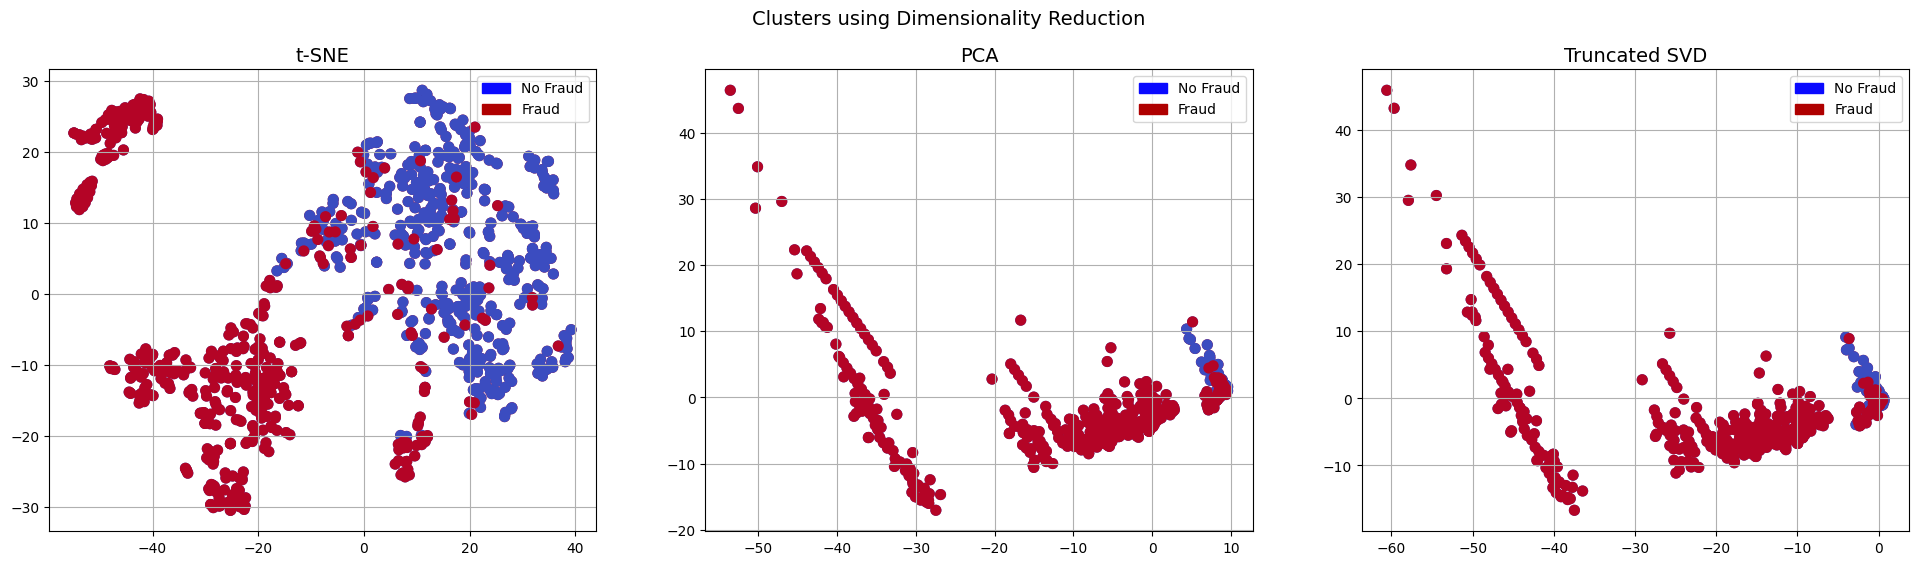

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# **05. Classification Models**

In [30]:
# Function to evaluate model
def evaluate_model(y_test, y_pred, dataset_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{dataset_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, precision, recall, f1

# **05.1. Logistic Regression**

## **05.1.1 Orginal Data**


In [31]:
# Step 1: Train Model on Original Data
X_orig = original_df.drop('Class', axis=1)
y_orig = original_df['Class']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)

Best Parameters for Logistic Regression (Original): {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression - Original Data Performance:
Accuracy: 0.9993
Precision: 0.8687
Recall: 0.6324
F1-Score: 0.7319
Confusion Matrix:
 [[85294    13]
 [   50    86]]


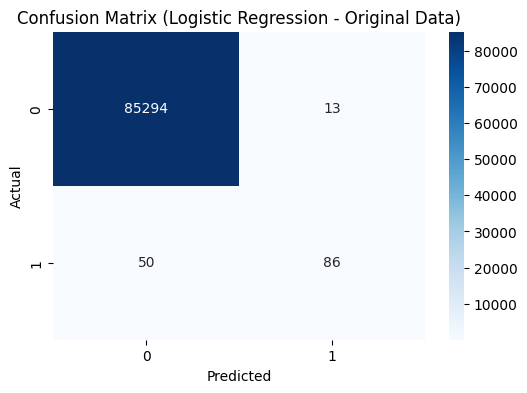

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
model_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=5, scoring='f1')
model_lr.fit(X_train_orig, y_train_orig)
print("Best Parameters for Logistic Regression (Original):", model_lr.best_params_)
y_pred_orig_lr = model_lr.predict(X_test_orig)
acc_orig_lr, prec_orig_lr, rec_orig_lr, f1_orig_lr = evaluate_model(y_test_orig, y_pred_orig_lr, "Logistic Regression - Original Data")

## **05.1.2. Random Underesampled**

Best Parameters for Logistic Regression (Method 2): {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression - Random Underesampled Performance:
Accuracy: 0.9437
Precision: 0.9638
Recall: 0.9236
F1-Score: 0.9433
Confusion Matrix:
 [[135   5]
 [ 11 133]]


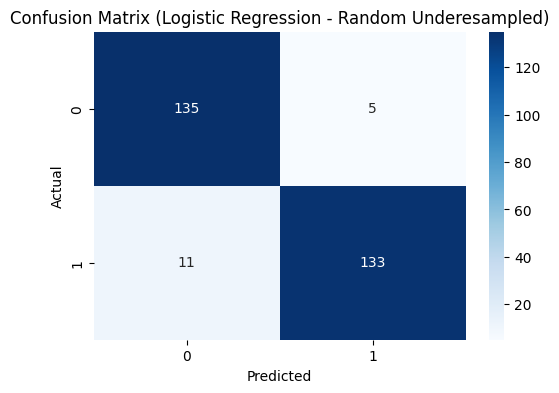

In [33]:
X_train_clean2, X_test_clean2, y_train_clean2, y_test_clean2 = train_test_split(X_resampled2, y_resampled2, test_size=0.3, random_state=42)
model_clean2_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=5, scoring='f1')
model_clean2_lr.fit(X_train_clean2, y_train_clean2)
print("Best Parameters for Logistic Regression (Method 2):", model_clean2_lr.best_params_)
y_pred_clean2_lr = model_clean2_lr.predict(X_test_clean2)
acc_clean2_lr, prec_clean2_lr, rec_clean2_lr, f1_clean2_lr = evaluate_model(y_test_clean2, y_pred_clean2_lr, "Logistic Regression - Random Underesampled")

## **05.1.3. Oversampled using SMOTE**

Best Parameters for Logistic Regression Oversampled using SMOTE: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression - Oversampled using SMOTE  Performance:
Accuracy: 0.9468
Precision: 0.9735
Recall: 0.9187
F1-Score: 0.9453
Confusion Matrix:
 [[82751  2129]
 [ 6913 78159]]


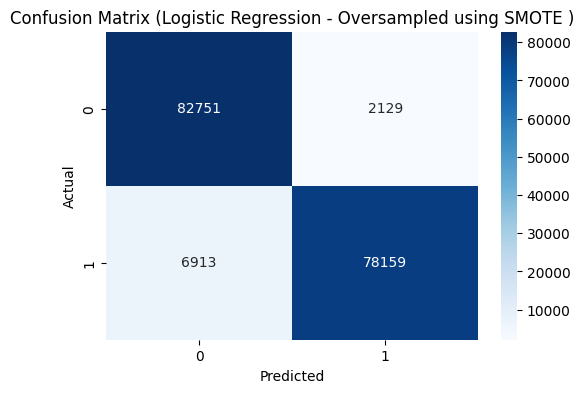

In [34]:
X_train_clean1, X_test_clean1, y_train_clean1, y_test_clean1 = train_test_split(X_resampled1, y_resampled1, test_size=0.3, random_state=42)
model_clean1_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=5, scoring='f1')
model_clean1_lr.fit(X_train_clean1, y_train_clean1)
print("Best Parameters for Logistic Regression Oversampled using SMOTE:", model_clean1_lr.best_params_)
y_pred_clean1_lr = model_clean1_lr.predict(X_test_clean1)
acc_clean1_lr, prec_clean1_lr, rec_clean1_lr, f1_clean1_lr = evaluate_model(y_test_clean1, y_pred_clean1_lr, "Logistic Regression - Oversampled using SMOTE ")

# **05.2. Random Forest**

## **05.2.1. Original Data**


Random Forest - Original Data Performance:
Accuracy: 0.9996
Precision: 0.9565
Recall: 0.8088
F1-Score: 0.8765
Confusion Matrix:
 [[85302     5]
 [   26   110]]


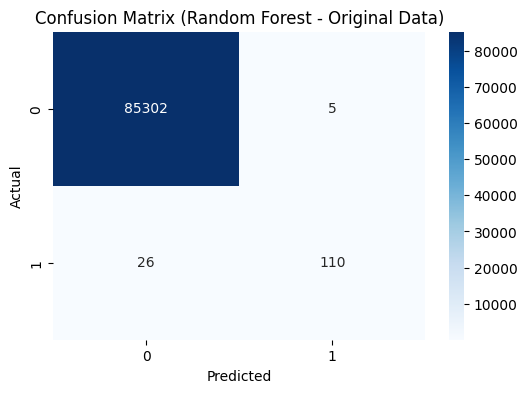

In [35]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, class_weight='balanced', n_jobs=-1, random_state=42)
model_rf.fit(X_train_orig, y_train_orig)
y_pred_orig_rf = model_rf.predict(X_test_orig)
acc_orig_rf, prec_orig_rf, rec_orig_rf, f1_orig_rf = evaluate_model(y_test_orig, y_pred_orig_rf, "Random Forest - Original Data")

## **05.2.2. Random Underesampled**


Random Forest - Random Underesampled Performance:
Accuracy: 0.9437
Precision: 0.9706
Recall: 0.9167
F1-Score: 0.9429
Confusion Matrix:
 [[136   4]
 [ 12 132]]


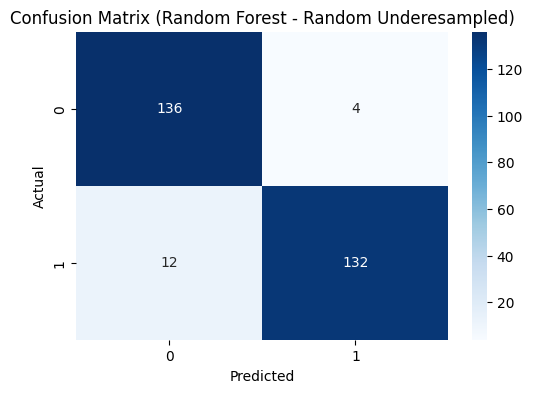

In [36]:
model_clean2_rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, class_weight='balanced', n_jobs=-1, random_state=42)
model_clean2_rf.fit(X_train_clean2, y_train_clean2)
y_pred_clean2_rf = model_clean2_rf.predict(X_test_clean2)
acc_clean2_rf, prec_clean2_rf, rec_clean2_rf, f1_clean2_rf = evaluate_model(y_test_clean2, y_pred_clean2_rf, "Random Forest - Random Underesampled")

## **05.2.3. Oversampled using SMOTE**


Random Forest - Oversampled using SMOTE Performance:
Accuracy: 0.9998
Precision: 0.9996
Recall: 1.0000
F1-Score: 0.9998
Confusion Matrix:
 [[84843    37]
 [    0 85072]]


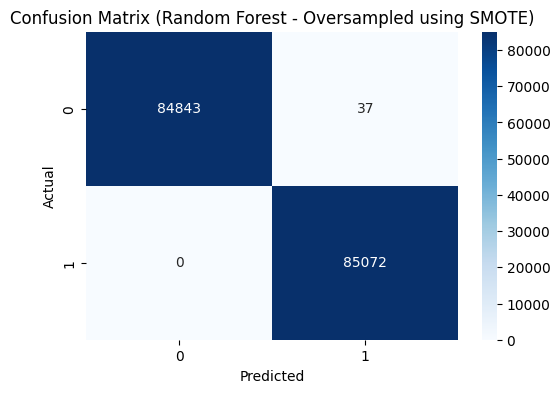

In [37]:
model_clean1_rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, class_weight='balanced', n_jobs=-1, random_state=42)
model_clean1_rf.fit(X_train_clean1, y_train_clean1)
y_pred_clean1_rf = model_clean1_rf.predict(X_test_clean1)
acc_clean1_rf, prec_clean1_rf, rec_clean1_rf, f1_clean1_rf = evaluate_model(y_test_clean1, y_pred_clean1_rf, "Random Forest - Oversampled using SMOTE")

# **05.3. SVM**

## **05.3.1. Original Data**

Best Parameters for SVM (Original): {'C': 1}

SVM - Original Data Performance:
Accuracy: 0.9991
Precision: 0.8462
Recall: 0.5662
F1-Score: 0.6784
Confusion Matrix:
 [[85293    14]
 [   59    77]]


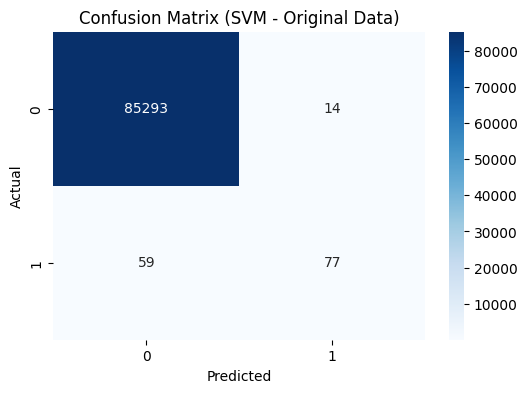

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import LinearSVC

param_grid_linear = {'C': [0.1, 1, 10]}
# Assign the GridSearchCV to model_svm
model_svm = GridSearchCV(LinearSVC(random_state=42, max_iter=10000), param_grid_linear, cv=5, scoring='f1', n_jobs=-1)

model_svm.fit(X_train_orig, y_train_orig)
print("Best Parameters for SVM (Original):", model_svm.best_params_)
y_pred_orig_svm = model_svm.predict(X_test_orig)
acc_orig_svm, prec_orig_svm, rec_orig_svm, f1_orig_svm = evaluate_model(y_test_orig, y_pred_orig_svm, "SVM - Original Data")

## **05.3.2. Random Underesampled**

Best Parameters for SVM (Random Underesampled): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

SVM - Random Underesampled Performance:
Accuracy: 0.9401
Precision: 0.9635
Recall: 0.9167
F1-Score: 0.9395
Confusion Matrix:
 [[135   5]
 [ 12 132]]


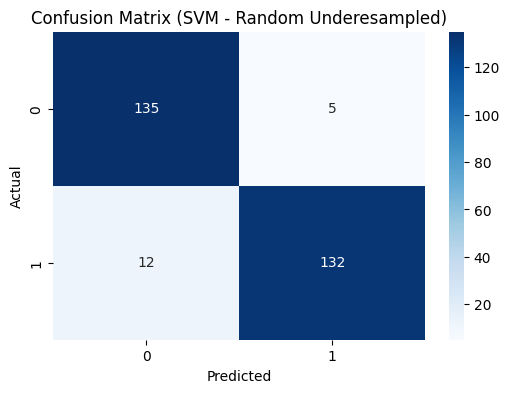

In [41]:
model_clean2_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='f1',n_jobs=-1)
model_clean2_svm.fit(X_train_clean2, y_train_clean2)
print("Best Parameters for SVM (Random Underesampled):", model_clean2_svm.best_params_)
y_pred_clean2_svm = model_clean2_svm.predict(X_test_clean2)
acc_clean2_svm, prec_clean2_svm, rec_clean2_svm, f1_clean2_svm = evaluate_model(y_test_clean2, y_pred_clean2_svm, "SVM - Random Underesampled")

## **05.3.3. Oversampled using SMOTE**


Best Parameters for SVM (Oversampled using SMOTE): {'C': 1}

SVM - Oversampled using SMOTE Performance:
Accuracy: 0.9414
Precision: 0.9780
Recall: 0.9031
F1-Score: 0.9391
Confusion Matrix:
 [[83154  1726]
 [ 8240 76832]]


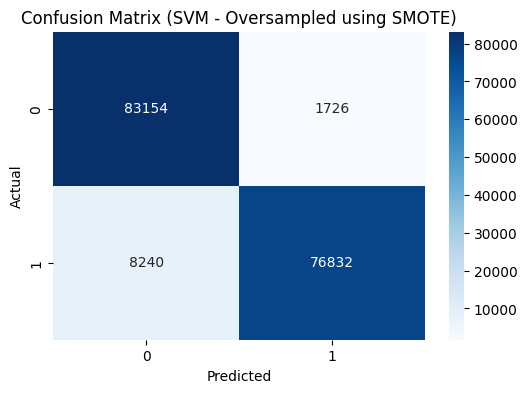

In [53]:
model_clean1_svm = GridSearchCV(LinearSVC(random_state=42), param_grid_linear, cv=5, scoring='f1',n_jobs=-1)
model_clean1_svm.fit(X_train_clean1, y_train_clean1)
print("Best Parameters for SVM (Oversampled using SMOTE):", model_clean1_svm.best_params_)
y_pred_clean1_svm = model_clean1_svm.predict(X_test_clean1)
acc_clean1_svm, prec_clean1_svm, rec_clean1_svm, f1_clean1_svm = evaluate_model(y_test_clean1, y_pred_clean1_svm, "SVM - Oversampled using SMOTE")

# **05.4. ANN**

In [42]:
def create_ann_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


## **05.4.1. Original Data**


2671/2671 ━━━━━━━━━━━━━━━━━━━━ 2s 806us/step

ANN - Original Data Performance:
Accuracy: 0.9984
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Confusion Matrix:
 [[85307     0]
 [  136     0]]


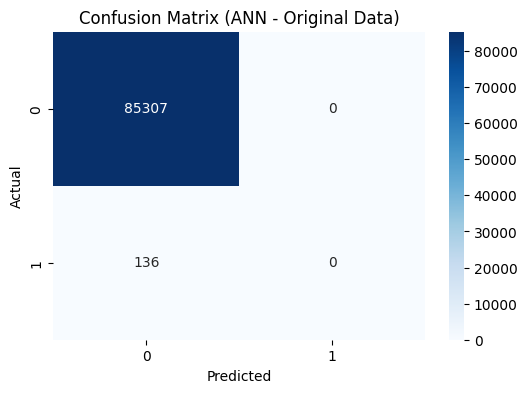

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
input_shape_orig = (X_train_orig.shape[1],)
ann_model_orig = create_ann_model(input_shape_orig)

# Train the ANN model
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history_orig = ann_model_orig.fit(X_train_orig, y_train_orig, epochs=10, batch_size=1024, validation_split=0.2, verbose=0,callbacks=[early_stop],)

# Evaluate the ANN model
y_pred_prob_orig = ann_model_orig.predict(X_test_orig)
y_pred_orig_ann = (y_pred_prob_orig > 0.5).astype(int)

acc_orig_ann, prec_orig_ann, rec_orig_ann, f1_orig_ann = evaluate_model(y_test_orig, y_pred_orig_ann, "ANN - Original Data")


## **05.4.2. Random Underesampled**


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

ANN - Random Underesampled Performance:
Accuracy: 0.9401
Precision: 0.9504
Recall: 0.9306
F1-Score: 0.9404
Confusion Matrix:
 [[133   7]
 [ 10 134]]


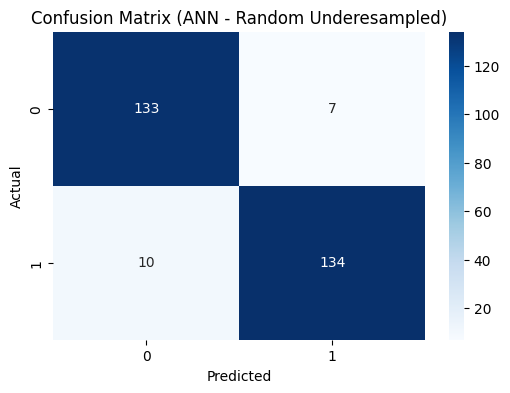

In [72]:
input_shape_clean2 = (X_train_clean2.shape[1],)
ann_model_clean2 = create_ann_model(input_shape_clean2)
history_clean2 = ann_model_clean2.fit(X_train_clean2, y_train_clean2, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
y_pred_prob_clean2 = ann_model_clean2.predict(X_test_clean2)
y_pred_clean2_ann = (y_pred_prob_clean2 > 0.5).astype(int)
acc_clean2_ann, prec_clean2_ann, rec_clean2_ann, f1_clean2_ann = evaluate_model(y_test_clean2, y_pred_clean2_ann, "ANN - Random Underesampled")

## **05.4.3. Oversampled using SMOTE**


5311/5311 ━━━━━━━━━━━━━━━━━━━━ 4s 830us/step

ANN - Oversampled using SMOTE Performance:
Accuracy: 0.9979
Precision: 0.9958
Recall: 1.0000
F1-Score: 0.9979
Confusion Matrix:
 [[84524   356]
 [    0 85072]]


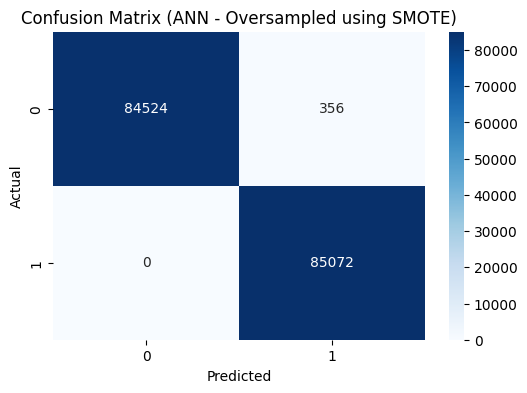

In [75]:
input_shape_clean1 = (X_train_clean1.shape[1],)
ann_model_clean1 = create_ann_model(input_shape_clean1)
history_clean1 = ann_model_clean1.fit(X_train_clean1, y_train_clean1, epochs=10, batch_size=1024, validation_split=0.2, verbose=0)
y_pred_prob_clean1 = ann_model_clean1.predict(X_test_clean1)
y_pred_clean1_ann = (y_pred_prob_clean1 > 0.5).astype(int)
acc_clean1_ann, prec_clean1_ann, rec_clean1_ann, f1_clean1_ann = evaluate_model(y_test_clean1, y_pred_clean1_ann, "ANN - Oversampled using SMOTE")

# **05.5. KNN**

In [67]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}


## **05.5.1. Original Data**

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters for KNN (Original): {'weights': 'distance', 'n_neighbors': 7}

KNN - Original Data Performance:
Accuracy: 0.9986
Precision: 1.0000
Recall: 0.1176
F1-Score: 0.2105
Confusion Matrix:
 [[85307     0]
 [  120    16]]


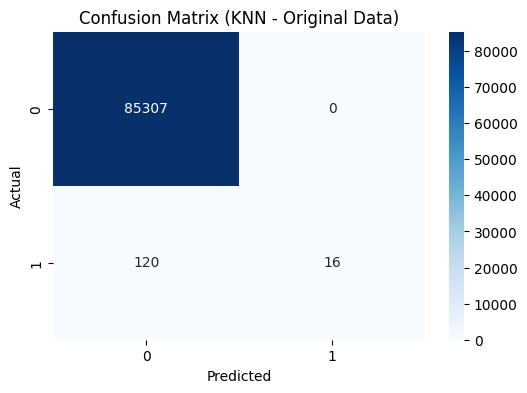

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

knn_classifier = KNeighborsClassifier()
skf = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
model_knn = RandomizedSearchCV(knn_classifier,
                               param_distributions=param_grid_knn,
                               scoring='roc_auc',
                               cv=skf,
                               n_iter=5,
                               n_jobs=-1,
                               verbose=1,
                               return_train_score=True)
model_knn.fit(X_train_orig, y_train_orig)
print("Best Parameters for KNN (Original):", model_knn.best_params_)
y_pred_orig_knn = model_knn.predict(X_test_orig)
acc_orig_knn, prec_orig_knn, rec_orig_knn, f1_orig_knn = evaluate_model(y_test_orig, y_pred_orig_knn, "KNN - Original Data")

## **05.5.2. Random Underesampled**


Best Parameters for KNN (Random Underesampled): {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}

KNN - Random Underesampled Performance:
Accuracy: 0.9437
Precision: 0.9848
Recall: 0.9028
F1-Score: 0.9420
Confusion Matrix:
 [[138   2]
 [ 14 130]]


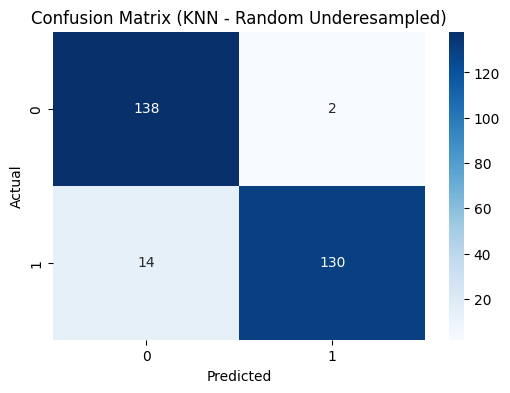

In [47]:
model_clean2_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
model_clean2_knn.fit(X_train_clean2, y_train_clean2)
print("Best Parameters for KNN (Random Underesampled):", model_clean2_knn.best_params_)
y_pred_clean2_knn = model_clean2_knn.predict(X_test_clean2)
acc_clean2_knn, prec_clean2_knn, rec_clean2_knn, f1_clean2_knn = evaluate_model(y_test_clean2, y_pred_clean2_knn, "KNN - Random Underesampled")


## **05.5.3. Oversampled using SMOTE**


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters for KNN (Oversampled using SMOTE): {'weights': 'distance', 'n_neighbors': 7}

KNN - Oversampled using SMOTE Performance:
Accuracy: 0.9985
Precision: 0.9970
Recall: 1.0000
F1-Score: 0.9985
Confusion Matrix:
 [[84628   252]
 [    0 85072]]


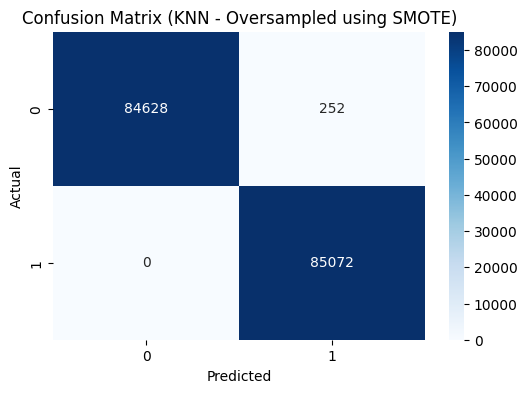

In [69]:
model_clean1_knn =RandomizedSearchCV(knn_classifier,
                               param_distributions=param_grid_knn,
                               scoring='roc_auc',
                               cv=skf,
                               n_iter=5,
                               n_jobs=-1,
                               verbose=1,
                               return_train_score=True)
model_clean1_knn.fit(X_train_clean1, y_train_clean1)
print("Best Parameters for KNN (Oversampled using SMOTE):", model_clean1_knn.best_params_)
y_pred_clean1_knn = model_clean1_knn.predict(X_test_clean1)
acc_clean1_knn, prec_clean1_knn, rec_clean1_knn, f1_clean1_knn = evaluate_model(y_test_clean1, y_pred_clean1_knn, "KNN - Oversampled using SMOTE")

## **06. Comparison**


In [77]:
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'ANN', 'KNN'],
    'Original Data Accuracy': [acc_orig_lr, acc_orig_rf, acc_orig_svm, acc_orig_ann, acc_orig_knn],
    'Original Data Precision': [prec_orig_lr, prec_orig_rf, prec_orig_svm, prec_orig_ann, prec_orig_knn],
    'Original Data Recall': [rec_orig_lr, rec_orig_rf, rec_orig_svm, rec_orig_ann, rec_orig_knn],
    'Original Data F1-score': [f1_orig_lr, f1_orig_rf, f1_orig_svm, f1_orig_ann, f1_orig_knn],
    'Undersampled Accuracy': [acc_clean2_lr, acc_clean2_rf, acc_clean2_svm, acc_clean2_ann, acc_clean2_knn],
    'Undersampled Precision': [prec_clean2_lr, prec_clean2_rf, prec_clean2_svm, prec_clean2_ann, prec_clean2_knn],
    'Undersampled Recall': [rec_clean2_lr, rec_clean2_rf, rec_clean2_svm, rec_clean2_ann, rec_clean2_knn],
    'Undersampled F1-score': [f1_clean2_lr, f1_clean2_rf, f1_clean2_svm, f1_clean2_ann, f1_clean2_knn],
    'SMOTE Accuracy': [acc_clean1_lr, acc_clean1_rf, acc_clean1_svm, acc_clean1_ann, acc_clean1_knn],
    'SMOTE Precision': [prec_clean1_lr, prec_clean1_rf, prec_clean1_svm, prec_clean1_ann, prec_clean1_knn],
    'SMOTE Recall': [rec_clean1_lr, rec_clean1_rf, rec_clean1_svm, rec_clean1_ann, rec_clean1_knn],
    'SMOTE F1-score': [f1_clean1_lr, f1_clean1_rf, f1_clean1_svm, f1_clean1_ann, f1_clean1_knn],
}


comparison_df = pd.DataFrame(results)

# Display the styled DataFrame
styled_df = comparison_df.style\
    .highlight_max(axis=0, color='lightgreen')\
    .highlight_min(axis=0, color='lightcoral')\
    .set_caption("Model Performance Comparison")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [('font-size', '16px'), ('color', 'black'), ('font-weight', 'bold')]
    }])

styled_df



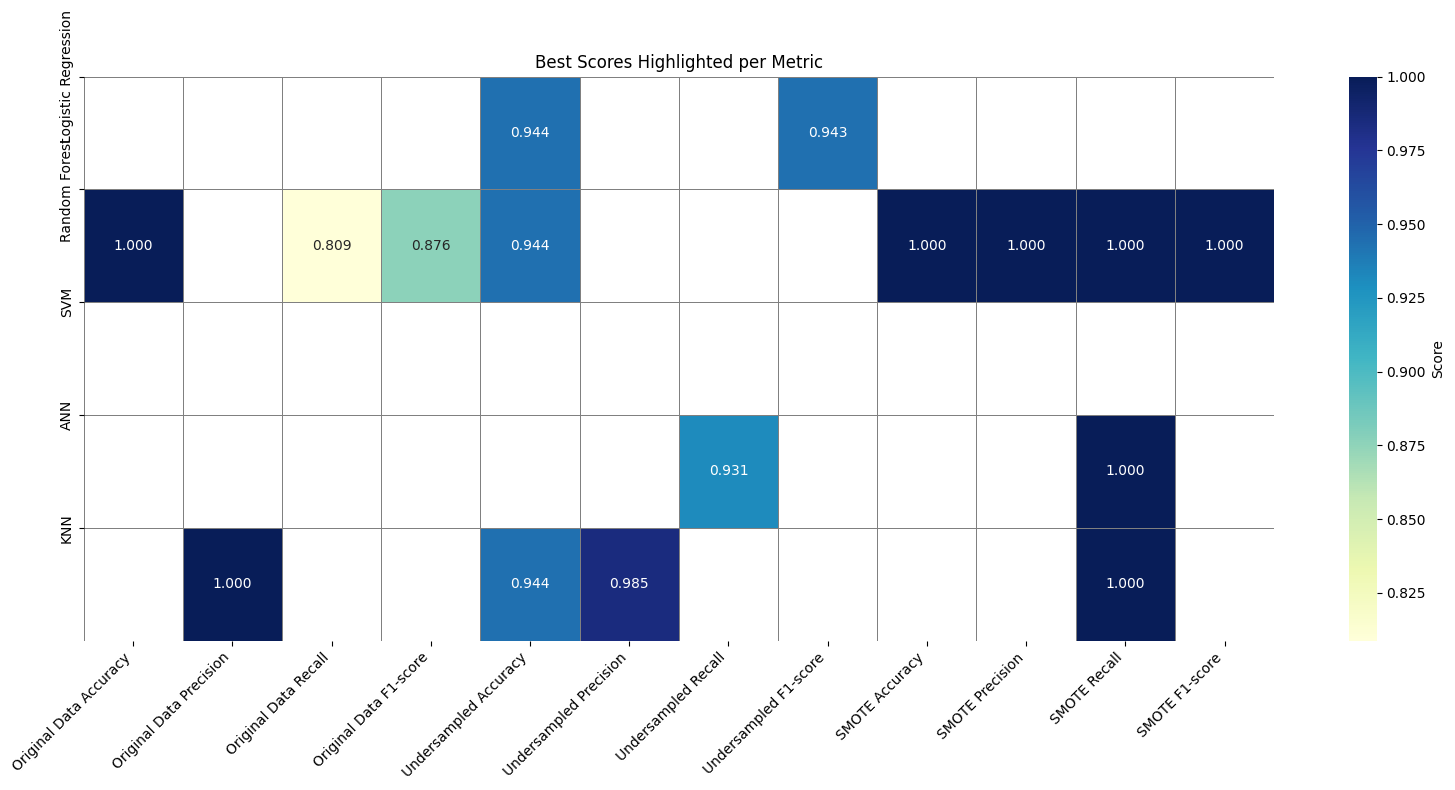

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = comparison_df.drop(columns=['Model']).eq(comparison_df.drop(columns=['Model']).max())

heat_data = comparison_df.drop(columns=['Model'])

plt.figure(figsize=(16, 8))
sns.heatmap(heat_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Score'},
            linewidths=0.5, linecolor='gray', mask=~mask)

plt.title('Best Scores Highlighted per Metric')
plt.xticks(rotation=45, ha='right')
plt.yticks(ticks=range(len(comparison_df)), labels=comparison_df['Model'])
plt.tight_layout()
plt.show()


# Federated Learning Here :https://www.kaggle.com/code/abdelrhmanzain/credit-card-fraud-federated-learning

**Note:** I made it at Kaggle because of versions problem at TensorFlow Federated lib.
